In [1]:
import numpy as np
from devito import Grid, TimeFunction, Eq, solve, Operator, Constant
from sympy import nsimplify, symbols

# Viz
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
# initialize the grid
grid = Grid(shape=(100,), extent=(500e-9,)) # extent is in m

In [63]:
grid.dimensions

(x,)

In [64]:
# carrier density is a function of time and space
n = TimeFunction(name="n", grid=grid, space_order=2)
n

n(t, x)

In [65]:
n.dt

Derivative(n(t, x), t)

In [66]:
n.laplace

Derivative(n(t, x), (x, 2))

In [67]:
n.forward

n(t + dt, x)

In [68]:
# Create constants
D = Constant(name="D")
S1 = Constant(name="S1")
S2 = Constant(name="S2")
tau_b = Constant(name="tau_b")
k1 = Constant(name="k1")
k2 = Constant(name="k2")

In [149]:
# create the continuity equation
eq = Eq(n.dt, ((D * n.laplace) - (k1 * n) - (k2 * n**2)), subdomain=grid.interior)
# eq = Eq(n.dt, (D * n.laplace - n/tau_b), subdomain=grid.interior)
eq

Eq(Derivative(n(t, x), t), D*Derivative(n(t, x), (x, 2)) - k1*n(t, x) - k2*n(t, x)**2)

In [150]:
# create the stencil
stencil = solve(eq, n.forward) # solve for the next time step

# create equation out of the stencil
eq_stencil = Eq(n.forward, stencil, subdomain=grid.interior)

eq_stencil

Eq(n(t + dt, x), dt*(D*(-2.0*n(t, x)/h_x**2 + n(t, x - h_x)/h_x**2 + n(t, x + h_x)/h_x**2) - k1*n(t, x) - k2*n(t, x)**2 + n(t, x)/dt))

In [151]:
# initial conditions - carrier density at t=0

# TODO find a better/elegant way to incorporate the exponential decay condition
x_ = np.linspace(0, grid.extent[0], grid.shape[0])

n.data[0] = 1e7 * np.exp(-x_/100e-9) # in carriers/m3

In [152]:
# Create boundary conditions

x, = grid.dimensions
t = grid.stepping_dim

bc = [ Eq(n[t+1, 0], (S1 / D) * n[t+1, 0] ) ] # left
bc += [ Eq(n[t+1, x-1], -(S2 / D) * n[t+1, x-1] ) ] # right

In [142]:
# Variable declarations

nt = 3 # time steps

dt = 1e-9 # size of the steps in s

In [154]:
# Create operator - create JIT-compiled and run C code

op = Operator([eq_stencil] + bc)

op(time=nt, dt=dt, D=0.9e-4, k1=1e7 * 1e-6, k2=1e-11 * 1e-12, S1=1e3 * 1e-2, S2=1e3 * 1e-2)
# op(time=nt, dt=dt, D=0.9e-4, S1=1e3 * 1e-2, S2=1e3 * 1e-2, tau_b=8e-6)

Operator `Kernel` run in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=2e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=1e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

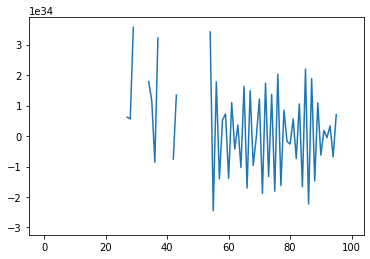

In [155]:
plt.plot(n.data[0])
# plt.yscale("log")

In [145]:
n.data

Data([[            nan,             nan,             nan,
                  -inf,            -inf,             inf,
                  -inf,            -inf,             inf,
                  -inf,             inf,            -inf,
       -2.36411068e+34,             inf,            -inf,
       -1.71175589e+34,             inf,            -inf,
                   inf,            -inf,             inf,
                  -inf,             inf,  1.78755806e+34,
                  -inf,             inf,            -inf,
        6.16569035e+33,  5.60238307e+33,  3.56879297e+34,
                  -inf, -2.91587665e+34,             inf,
                  -inf,  1.78802749e+34,  1.15734507e+34,
       -8.59270089e+33,  3.21728980e+34,            -inf,
                   inf,            -inf,             inf,
       -7.54344519e+33,  1.34289928e+34,            -inf,
                   inf,            -inf,  1.48242589e+34,
                   inf,            -inf,             inf,
              

In [136]:
bc

[Eq(n[t + 1, 0], S1*n[t, 0]/D), Eq(n[t + 1, x - 1], -S2*n[t, x - 1]/D)]